# Converting a From-Scratch GPT Architecture to Llama 2

1. In this notebook, we convert the original GPT architecture into a Llama 2 model step by step (note the GPT and GPT-2 share the same architecture)
2. For more information, please see the Llama 2 paper: [Llama 2: Open Foundation and Fine-Tuned Chat Models (2023)](https://arxiv.org/pdf/2307.09288)


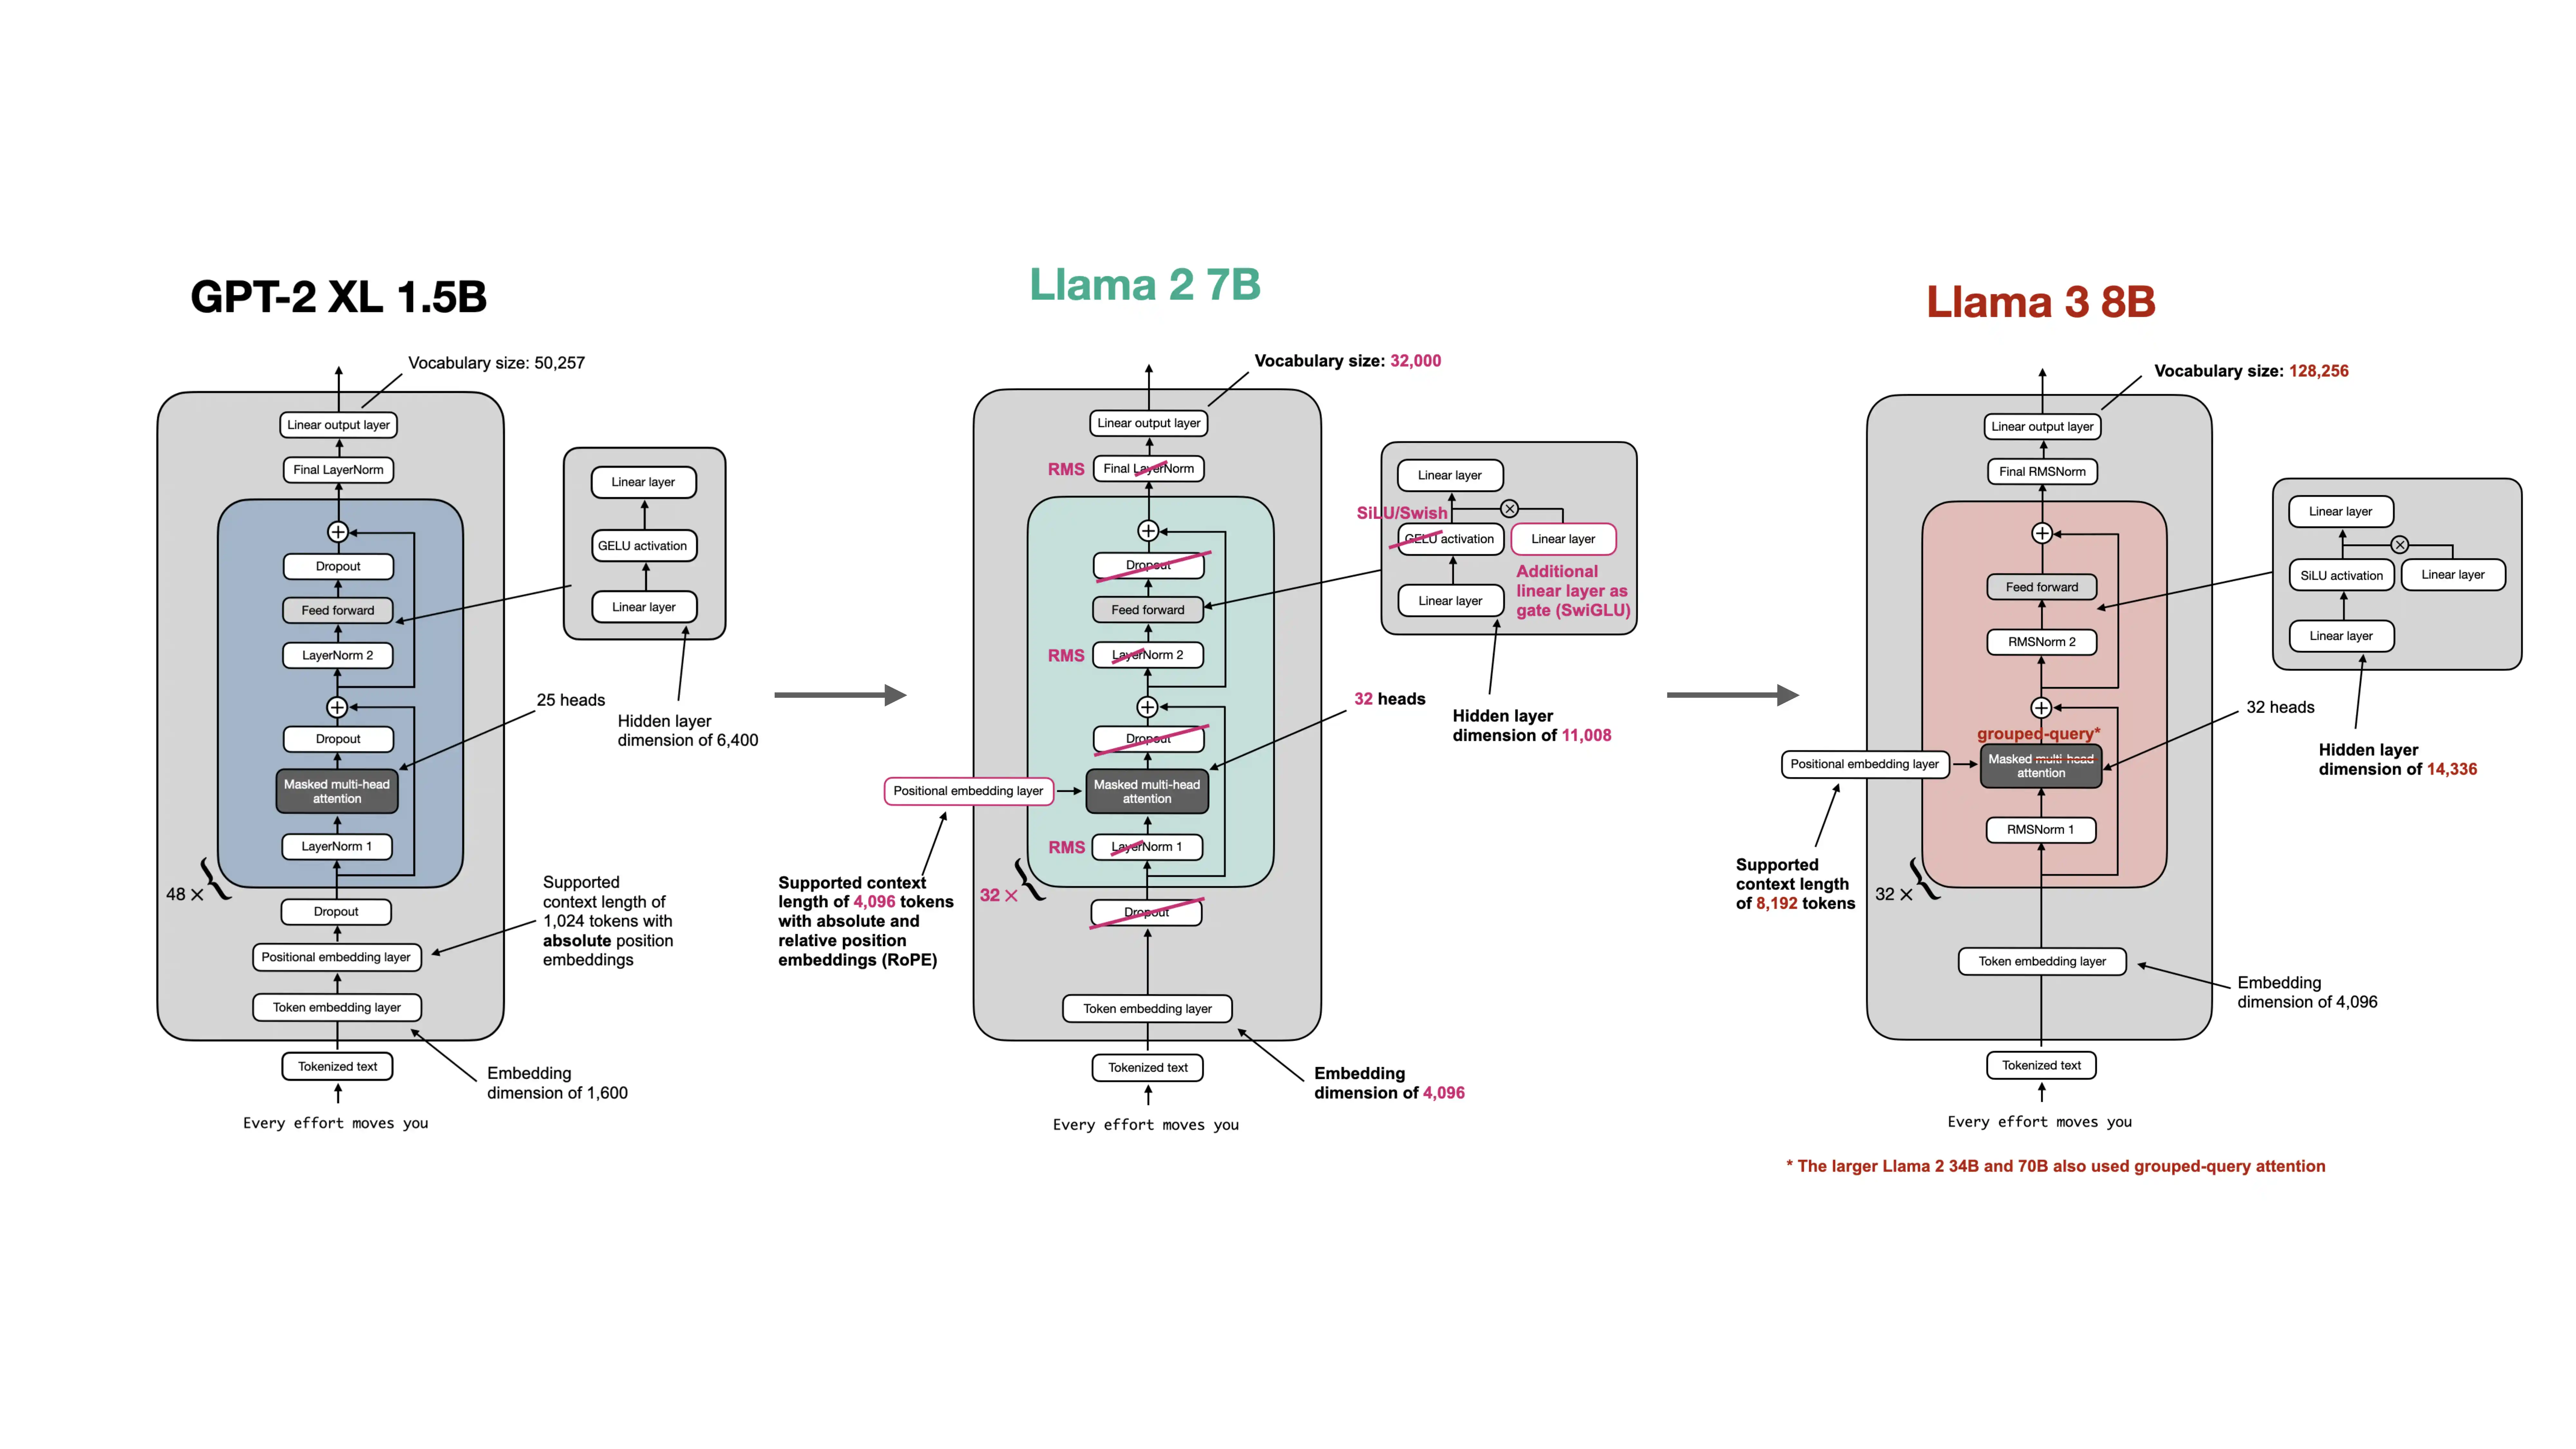

Packages that are being used in this notebook:

In [2]:
from importlib.metadata import version

pkgs = [
    "huggingface_hub",  # to download pretrained weights
    "sentencepiece",    # to implement the tokenizer
    "torch",            # to implement the model
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

huggingface_hub version: 0.30.1
sentencepiece version: 0.2.0


# 1. Convert the GPT model implementation step by step

## 1.1 Replace LayerNorm with RMSNorm layer

- First, we replace LayerNorm by Root Mean Square Layer Normalization (RMSNorm)
- LayerNorm normalizes inputs using mean and variance, while RMSNorm uses only the root mean square, which improves computational efficiency
- The RMSNorm operation is as follows, where $x$ is the input $\gamma$ is a trainable parameter (vector), and $\epsilon$ is a small constant to avoid zero-division errors:

$$y_i = \frac{x_i}{\text{RMS}(x)} \gamma_i, \quad \text{where} \quad \text{RMS}(x) = \sqrt{\epsilon + \frac{1}{n} \sum x_i^2}$$

In [ ]:
import torch
import torch.nn as nn


#####################################
# GPT LayerNorm Function 
#####################################

# class LayerNorm(nn.Module):
#     def __init__(self, emb_dim):
#         super().__init__()
#         self.eps = 1e-5
#         self.scale = nn.Parameter(torch.ones(emb_dim))
#         self.shift = nn.Parameter(torch.zeros(emb_dim))

#     def forward(self, x):
#         mean = x.mean(dim=-1, keepdim=True)
#         var = x.var(dim=-1, keepdim=True, unbiased=False)
#         norm_x = (x - mean) / torch.sqrt(var + self.eps)
#         return self.scale * norm_x + self.shift

class RMSNorm(nn.Module):
    def __init__(self,emb_dim,eps=1e-5):
        super().__init__()
        self.emb_dim = emb_dim
        self.eps = eps
        self.weight = nn.parameter(torch.ones(emb_dim)).float()
    
    def forward(self,x):
        means = x.pow(2).mean(dim=-1, keepdim=True) # this calculates the summation inside sqrt.
        x_normed = x * torch.rsqrt(means + self.eps) # using torch.rsqrt we calculated and reciprocal the inner value
        return (x_normed * self.weight).to(dtype=x.dtype) # now we multiply weight vector with x / RMS(x)


The following code cell checks that this implementation works the same as PyTorch's built-in implementation:

In [ ]:
torch.manual_seed(123)

example_batch = torch.randn(2, 3, 4)

rms_norm = RMSNorm(emb_dim=example_batch.shape[-1])
rmsnorm_pytorch = torch.nn.RMSNorm(example_batch.shape[-1], eps=1e-5)

assert torch.allclose(rms_norm(example_batch), rmsnorm_pytorch(example_batch))

## 1.2 Replace GELU with SiLU activation

- Llama uses the SiLU activation function (instead of GELU), which is also known as the Swish function:

$$
\text{silu}(x) = x \cdot \sigma(x), \quad \text{where} \quad \sigma(x) \text{ is the logistic sigmoid.}
$$

- For more information, see the SiLU paper: [Sigmoid-Weighted Linear Units for Neural Network Function Approximation in Reinforcement Learning (2017)](https://arxiv.org/abs/1702.03118)

In [ ]:
#####################################
# GELU Function used in GPT model
#####################################

# class GELU(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, x):
#         return 0.5 * x * (1 + torch.tanh(
#             torch.sqrt(torch.tensor(2.0 / torch.pi)) *
#             (x + 0.044715 * torch.pow(x, 3))
#         ))


class SiLU(nn.Module):
    def __init__(self):
        super(SiLU).__init__()
    
    def forward(self,x):
        return x * torch.sigmoid(x)

In [ ]:
silu = SiLU()

assert torch.allclose(silu(example_batch), torch.nn.functional.silu(example_batch))

&nbsp;
## 1.3 Update the FeedForward module

- In fact, Llama uses a "Gates Linear Unit" (GLU) variant of SiLU called SwiGLU, which essentially results in a slightly differently structured `FeedForward` module
- SwiGLU uses a gating mechanism in the feedforward layer, with the formula:

$$\text{SwiGLU}(x) = \text{SiLU}(\text{Linear}_1(x)) * (\text{Linear}_2(x))$$

- Here, $\text{Linear}_1$ and $\text{Linear}_2$ are two linear layers, and $*$ denotes element-wise multiplication
- The third linear layer, $\text{Linear}_3$, is applied after this gated activation

- For more information, see SwiGLU paper: [GLU Variants Improve Transformer (2020)](https://arxiv.org/abs/2002.05202)

In [ ]:
#####################################
# FeedForward modue from GPT uses GELU as shown 
#####################################
# class FeedForward(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
#             GELU(),
#             nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
#         )

#     def forward(self, x):
#         return self.layers(x)

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"] ,cfg["emb_dim"], dtype=cfg["dtype"], bias=False)
        self.silu = SiLU()

    def forward(self,x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = self.silu(x_fc1) * x_fc2  # silu of fc1 is multiplied by fc2 then passed through fc3 as shown below.
        return self.fc3(x)

1. Note that we also added a dtype=cfg["dtype"] setting above, which will allow us to load the model directly in lower precision formats later to reduce memory usage (versus instantiating it in the original 32-bit precision format and then converting it)
2. We also set bias=False since Llama doesn't use any bias units